In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# N: Normal beat
# S: Supraventricular premature beat
# V: Premature ventricular contraction
# F: Fusion of ventricular and normal beat
# Q: Unclassifiable beat
# M: myocardial infarction

# train set

In [3]:
%%time
dir = Path('/kaggle/input/train')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

CPU times: user 5.26 ms, sys: 968 µs, total: 6.22 ms
Wall time: 27.2 ms


<timed exec>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<timed exec>:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Filepath,Label


In [ ]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [ ]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

N    640
Q    640
S    640
F    640
M    640
V    640
Name: Label, dtype: int64

In [4]:
#dataframe_train

# test set

In [5]:
%%time
dir = Path('/kaggle/input/test')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

CPU times: user 2.14 ms, sys: 0 ns, total: 2.14 ms
Wall time: 2.09 ms


<timed exec>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<timed exec>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Filepath,Label


In [ ]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [ ]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

M    160
F    160
Q    160
N    160
V    160
S    160
Name: Label, dtype: int64

In [6]:
#dataframe_test

# Image generators

In [ ]:
def gray_torgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.merge((image,image,image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255,
    validation_split=0.2

)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255
)

In [ ]:
size=224
color_mode='rgb'
batch_size=32

train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.


In [ ]:
test_images.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

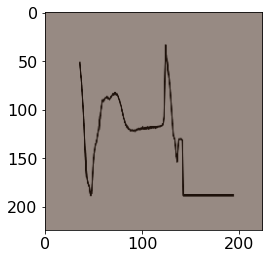

In [ ]:
plt.imshow(test_images[0][0][3])

# Modeling

In [ ]:
from tensorflow.keras.applications import MobileNetV2
pretrained_model = MobileNetV2(
                              input_shape=(224,224,3),
                              include_top= False,
                              weights='imagenet',
                              pooling='avg'
                              )

pretrained_model.trainable = False


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

model = Sequential ([
                        pretrained_model,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(6, activation='softmax')
                    ])


model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten_6 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 390       
Total params: 2,430,598
Trainable params: 172,614
Non-trainable params: 2,257,984
______________________________________

In [ ]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',
            metrics=['accuracy',
                     'Precision',
                     'Recall',
                     tf.keras.metrics.AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False
                                    )])

In [ ]:
%%time
result=model.fit(
    train_images,
    steps_per_epoch=3072//32,
    validation_data=val_images,
    validation_steps=768//32,
    epochs=20,
    callbacks=[checkpoint]
)
# 50 epochs

Epoch 1/20
96/96 [==============================] - 24s 213ms/step - loss: 0.7007 - accuracy: 0.7477 - precision: 0.8537 - recall: 0.6439 - auc_6: 0.9523 - val_loss: 0.3336 - val_accuracy: 0.8841 - val_precision: 0.9142 - val_recall: 0.8464 - val_auc_6: 0.9898

Epoch 00001: val_accuracy improved from -inf to 0.88411, saving model to best_model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
96/96 [==============================] - 19s 196ms/step - loss: 0.3376 - accuracy: 0.8792 - precision: 0.8991 - recall: 0.8590 - auc_6: 0.9874 - val_loss: 0.2477 - val_accuracy: 0.9036 - val_precision: 0.9158 - val_recall: 0.8919 - val_auc_6: 0.9939

Epoch 00002: val_accuracy improved from 0.88411 to 0.90365, saving model to best_model.h5
Epoch 3/20
96/96 [==============================] - 18s 191ms/step - loss: 0.2738 - accuracy: 0.8929 - precision: 0.9072 - recall: 0.8844 - auc_6: 0.9916 - val_loss: 0.2008 - val_accuracy: 0.9336 - val_precision: 0.9456 - val_recall: 0.9271 - val_auc_6: 0.9961

Epoch 00003: val_accuracy improved from 0.90365 to 0.93359, saving model to best_model.h5
Epoch 4/20
96/96 [==============================] - 19s 201ms/step - loss: 0.2124 - accuracy: 0.9202 - precision: 0.9299 - recall: 0.9150 - auc_6: 0.9948 - val_loss: 0.2125 - val_accuracy: 0.9062 - val_precision: 0.9258 - val_recall: 0.8932 - val_auc_6: 0.9952

Epoch 00004: val_accuracy did not 

# Result

In [ ]:
from keras.models import load_model
best_model=load_model('/kaggle/working/best_model.h5')
results = best_model.evaluate(test_images, verbose=0)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.4f}%".format(results[1] * 100))
print("Test Precision: {:.4f}%".format(results[2] * 100))
print("   Test Recall: {:.4f}%".format(results[3] * 100))
print("      Test AUC: {:.4f}".format(results[4] ))


     Test Loss: 0.1633
 Test Accuracy: 94.2708%
Test Precision: 94.5435%
   Test Recall: 93.8542%
      Test AUC: 0.9952


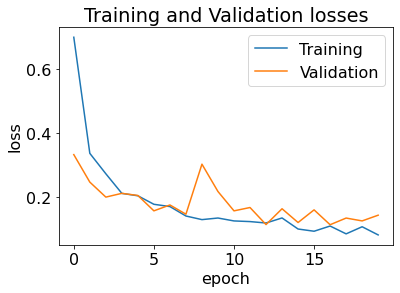

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

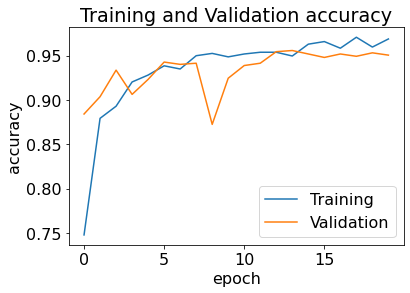

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')


In [ ]:
y_pred = best_model.predict(test_images)
y_pred

array([[2.0290765e-03, 9.7887325e-01, 3.2635403e-09, 1.0769176e-06,
        1.7667716e-02, 1.4289492e-03],
       [9.6745557e-01, 2.6842259e-04, 8.0768962e-07, 1.3301371e-06,
        3.1352989e-02, 9.2092599e-04],
       [2.2884159e-04, 3.2746825e-10, 1.3659179e-04, 9.9149537e-01,
        1.9106203e-07, 8.1389267e-03],
       ...,
       [9.9878544e-01, 1.6128587e-07, 2.8034648e-05, 1.2549354e-05,
        1.1822071e-05, 1.1619834e-03],
       [2.3939092e-05, 6.3032091e-01, 2.1759383e-09, 1.0609593e-07,
        3.6951751e-01, 1.3752066e-04],
       [3.3606446e-07, 1.9142211e-14, 9.9993813e-01, 6.1562467e-05,
        1.1943301e-10, 3.5883470e-08]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 3, 3, 3, 1, 0, 1, 2, 2, 5, 3, 1, 2, 4, 4, 2, 4, 5, 2, 1, 3,
       4, 2, 4, 4, 1, 3, 2, 5, 3, 1, 2, 2, 2, 3, 1, 5, 1, 5, 0, 5, 1, 3,
       1, 4, 1, 4, 1, 0, 2, 2, 0, 3, 3, 0, 0, 0, 4, 0, 3, 5, 2, 5, 3, 0,
       5, 3, 1, 5, 1, 5, 5, 5, 5, 3, 0, 2, 0, 2, 0, 0, 1, 3, 2, 5, 2, 4,
       5, 5, 4, 5, 0, 1, 4, 2, 4, 1, 4, 2, 5, 2, 4, 5, 1, 1, 1, 0, 1, 4,
       2, 4, 4, 5, 2, 2, 2, 3, 3, 3, 0, 2, 4, 0, 1, 3, 4, 1, 1, 5, 4, 5,
       2, 4, 2, 0, 3, 2, 2, 0, 4, 2, 1, 3, 0, 5, 4, 3, 2, 1, 5, 3, 4, 4,
       1, 2, 1, 3, 5, 3, 3, 5, 5, 3, 4, 1, 4, 0, 3, 0, 5, 4, 1, 1, 0, 5,
       2, 5, 5, 2, 5, 0, 1, 3, 4, 1, 4, 1, 4, 2, 1, 4, 3, 4, 1, 4, 0, 0,
       5, 1, 5, 5, 0, 0, 1, 2, 0, 2, 4, 0, 0, 2, 0, 4, 2, 4, 4, 0, 5, 0,
       0, 0, 3, 2, 1, 2, 0, 5, 2, 4, 1, 2, 4, 0, 5, 2, 5, 5, 4, 1, 3, 2,
       4, 4, 5, 0, 0, 3, 2, 3, 2, 4, 2, 3, 4, 4, 3, 3, 0, 0, 4, 0, 2, 1,
       5, 1, 3, 2, 5, 5, 1, 5, 3, 0, 0, 2, 0, 1, 4, 5, 4, 4, 0, 0, 2, 3,
       3, 2, 0, 5, 0, 3, 1, 2, 1, 0, 1, 0, 0, 2, 3,

# classification report & confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
print(cm)

report = classification_report(test_images.labels, y_pred, target_names=['F', 'M', 'N', 'Q', 'S', 'V'],digits=4)
print(report )

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)

report.to_csv('classification report.csv', index=True)



[[153   0   0   0   2   5]
 [  0 155   0   0   5   0]
 [  0   0 160   0   0   0]
 [  0   0   7 153   0   0]
 [  3  13   0   0 141   3]
 [ 16   0   0   0   1 143]]
              precision    recall  f1-score   support

           F     0.8895    0.9563    0.9217       160
           M     0.9226    0.9688    0.9451       160
           N     0.9581    1.0000    0.9786       160
           Q     1.0000    0.9563    0.9776       160
           S     0.9463    0.8812    0.9126       160
           V     0.9470    0.8938    0.9196       160

    accuracy                         0.9427       960
   macro avg     0.9439    0.9427    0.9425       960
weighted avg     0.9439    0.9427    0.9425       960



# ploting the confusion matrix


Confusion matrix, without normalization


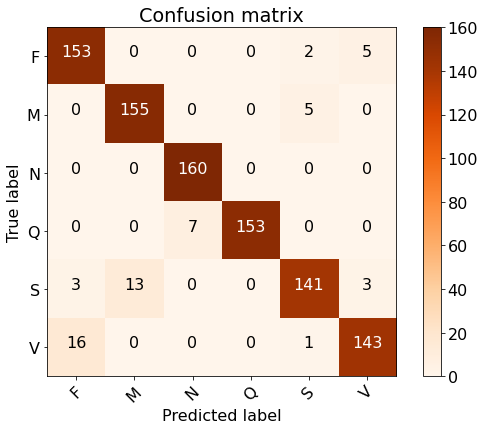

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '20'


plot_confusion_matrix(cm, classes=['F', 'M', 'N', 'Q', 'S', 'V'],normalize=False,title='Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')


Normalized confusion matrix


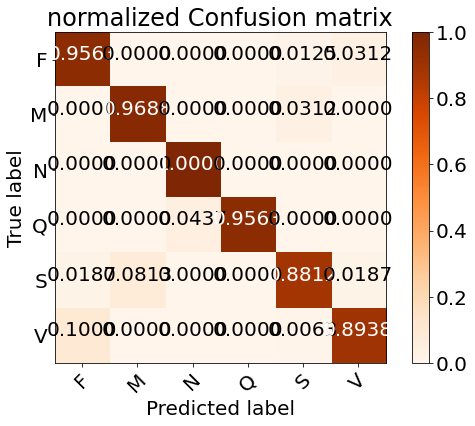

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '16'


plot_confusion_matrix(cm, classes=['F', 'M', 'N', 'Q', 'S', 'V'],normalize=True,title='normalized Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('normalized confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')
